In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection

In [3]:
url = 'https://gcs-youbike2-linebot.microprogram.tw/latest-data/youbike-station.csv'
r = requests.request('GET', url)

In [4]:
csv_file = bytes.decode( r.content, 'utf-8');
file = open('youbike-res.csv', 'w')
file.write(r.text)
file.close()

In [24]:
bikes_station_raw = pd.read_csv('youbike-res.csv')

In [57]:
# Analyze Raw data
main_df = bikes_station_raw.copy()

# Double check with cleaned df 
# main_df = bikes_station_clean.copy()

# Validate & clean the dataset

In [7]:
main_df.shape

(7843, 17)

In [58]:
main_df.columns

Index(['id', 'name', 'type', 'space', 'full', 'empty', 'bike_yb1', 'bike_yb2',
       'bike_eyb', 'city', 'area', 'lat', 'lng', 'place_id', 'address',
       'is_open', 'updated_at'],
      dtype='object')

**Columns are understood as follows:**
- id: unique identifier per bike station
- type: ??
- space: total available bike slots per station (= full + empty)
- full: nbr of occupied slots 
- empty: nbr of available slots for parking
- bike_yb1: ??
- bike_yb2: ??
- bike_eyb: ??
- city: city where bike station is located
- area: city's district where bike station is located
- lat: latitude coordinate of bike station
- lng: longitude coordinate of bike station
- place_id: ??
- address: postal address of bike station
- is_open: ??
- updated_at: timestamp of data in unix epoch

### Check types & missing values

In [13]:
display(main_df.info())
display(main_df.isna().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7843 entries, 0 to 7842
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          7843 non-null   int64  
 1   name        7843 non-null   object 
 2   type        7843 non-null   int64  
 3   space       7843 non-null   int64  
 4   full        7843 non-null   int64  
 5   empty       7843 non-null   int64  
 6   bike_yb1    7843 non-null   int64  
 7   bike_yb2    7843 non-null   int64  
 8   bike_eyb    7843 non-null   int64  
 9   city        7719 non-null   object 
 10  area        7843 non-null   object 
 11  lat         7843 non-null   float64
 12  lng         7843 non-null   float64
 13  place_id    0 non-null      float64
 14  address     7843 non-null   object 
 15  is_open     7843 non-null   int64  
 16  updated_at  7843 non-null   int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 1.0+ MB


None

id            False
name          False
type          False
space         False
full          False
empty         False
bike_yb1      False
bike_yb2      False
bike_eyb      False
city           True
area          False
lat           False
lng           False
place_id       True
address       False
is_open       False
updated_at    False
dtype: bool

**Observation**
- place_id contains no value
- city has empty values
- updated_at is an int64

In [35]:
main_df.drop(main_df[main_df["city"].isna()].index, inplace=True)
main_df["ts"] = pd.to_datetime(main_df["updated_at"], unit="s")
main_df.drop(labels=["place_id", "updated_at"], axis=1, inplace=True)

### Discard irrelevant features

In [36]:
main_df.drop(labels=["name", "area", "address"], axis=1, inplace=True)

### Check range and distribution of values

#### Categorical

In [37]:
main_df_cat = main_df.select_dtypes(include=["category", "object"])
#TODO: set "type" to a category var to include in categorical

In [40]:
for col in main_df_cat.columns:
    unique_values = main_df[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'city': ['TaiNanShi' 'TaoYuanShi' 'XinBeiShi' 'MiaoLiXian' 'TaiBeiShi'
 'KaoXiongShi' 'JiaYiShi' 'XinZhuXian' 'PingDongXian' 'TaiZhongShi'
 'XinZhuShi' 'XinZhuKeXueGong']


In [39]:
#Map city to ascii chars
city_name_glossary = {"新北市": "XinBeiShi",
                      "台北市": "TaiBeiShi",
                      "台中市":"TaiZhongShi",
                      "高雄市":"KaoXiongShi",
                      "桃園市":"TaoYuanShi",
                      "臺南市": "TaiNanShi",
                      "嘉義市": "JiaYiShi",
                      "屏東縣": "PingDongXian",
                      "新竹市": "XinZhuShi",
                      "新竹縣": "XinZhuXian",
                      "苗栗縣" : "MiaoLiXian",
                      "新竹科學工業園區": "XinZhuKeXueGong"}  

#TODO Need to catch KeyError and set default value. 
main_df["city"] = main_df.apply(lambda x: city_name_glossary[x["city"]], axis=1)


#### Numerical

In [41]:
main_df_num = main_df.drop(labels=main_df_cat.columns, axis=1)

In [42]:
main_df_num.describe()

,id,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb,lat,lng,is_open,ts
count,7.719000e+03,7719.000000,7719.000000,7719.000000,7719.000000,7719.000000,7719.000000,7719.000000,7719.000000,7719.000000,7719.000000,7719
mean,4.323405e+08,1.863583,20.992357,6.488535,13.332556,0.851017,5.453815,0.183703,24.235829,120.694232,0.979401,2024-01-04 07:38:00.498510336
min,1.001000e+03,1.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-21 04:43:40
25%,5.001090e+08,2.000000,14.000000,1.000000,7.000000,0.000000,0.000000,0.000000,23.479212,120.500780,1.000000,2024-01-04 10:52:17
50%,5.003041e+08,2.000000,18.000000,5.000000,11.000000,0.000000,4.000000,0.000000,24.939500,121.223400,1.000000,2024-01-04 10:52:17
75%,5.010011e+08,2.000000,25.000000,9.000000,18.000000,0.000000,8.000000,0.000000,25.032600,121.484955,1.000000,2024-01-04 10:52:17
max,5.082010e+08,2.000000,106.000000,80.000000,98.000000,59.000000,80.000000,17.000000,25.293010,122.000000,5.000000,2024-01-04 10:52:20
std,1.718451e+08,0.343253,11.554128,6.637806,10.722098,3.316169,6.422332,0.723277,1.525511,6.134469,0.429498,NaN


**Observations**
- Empty has negative values
- Some long/lat coordinates are outside of Taiwan
- Some ts shows stale data (many days older than latest ts)

In [ ]:
main_df.drop(main_df[main_df["empty"] < 0

In [43]:
main_df_num.columns

Index(['id', 'type', 'space', 'full', 'empty', 'bike_yb1', 'bike_yb2',
       'bike_eyb', 'lat', 'lng', 'is_open', 'ts'],
      dtype='object')

In [51]:
%matplotlib inline

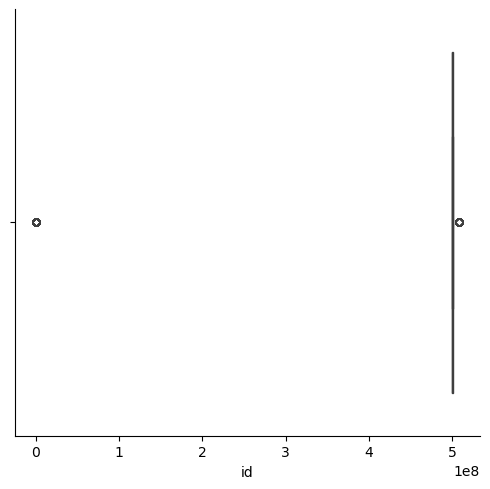

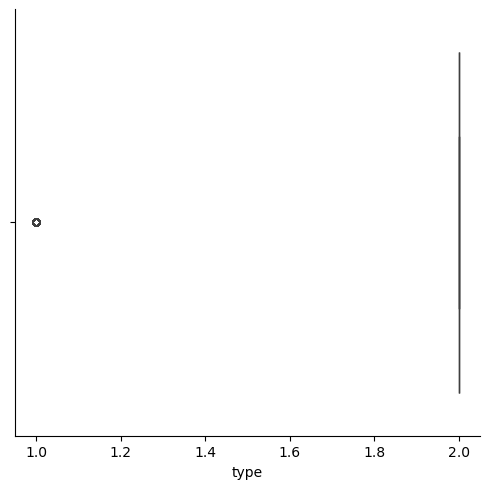

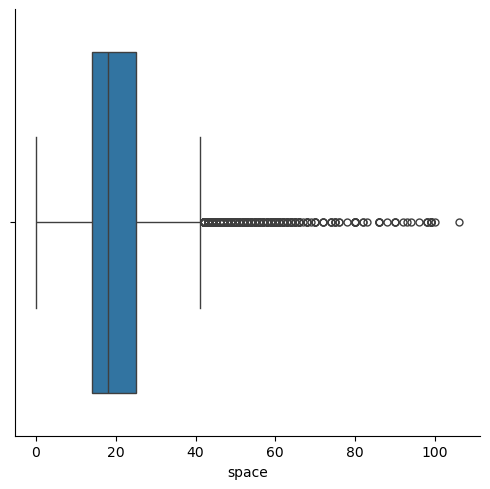

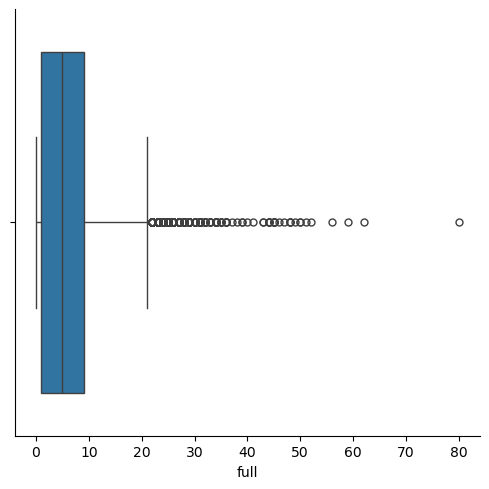

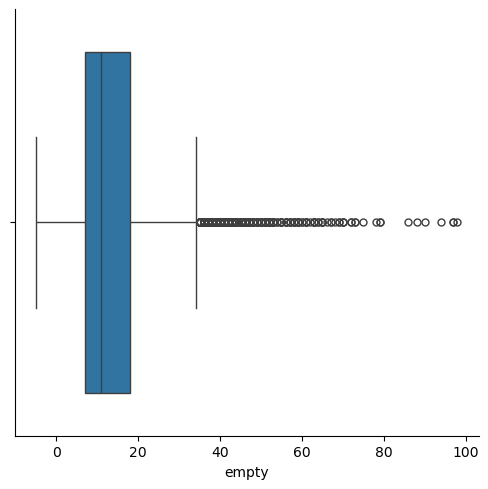

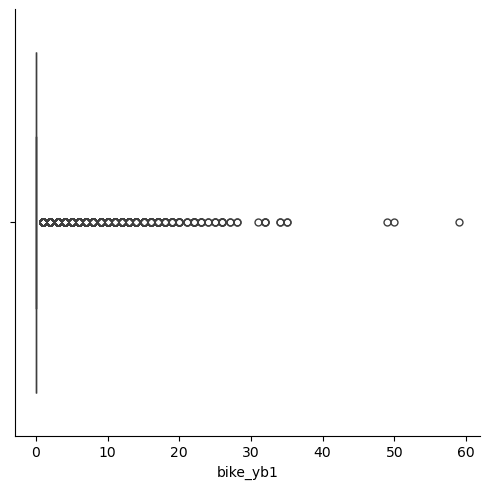

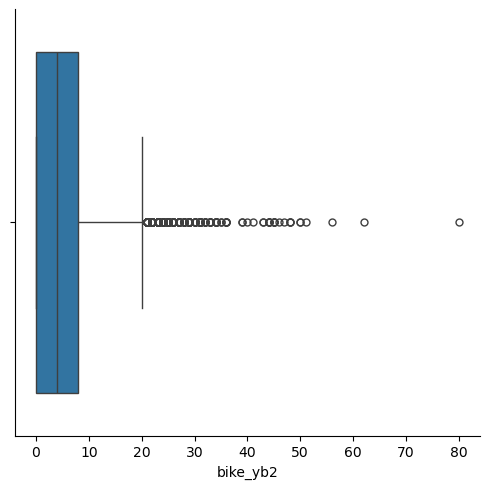

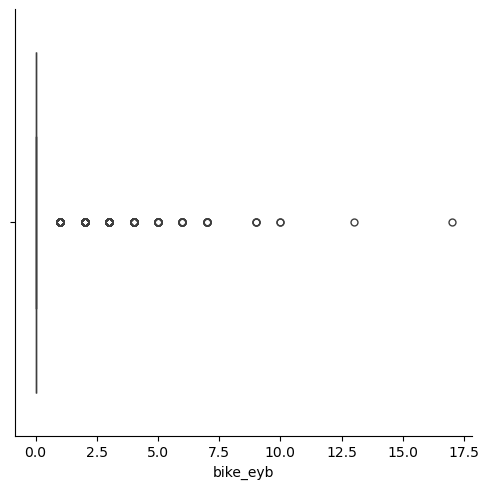

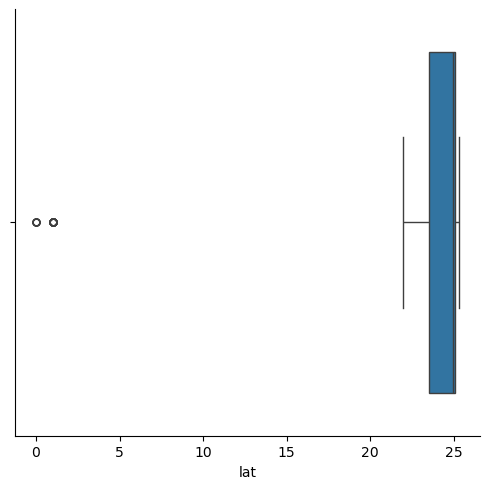

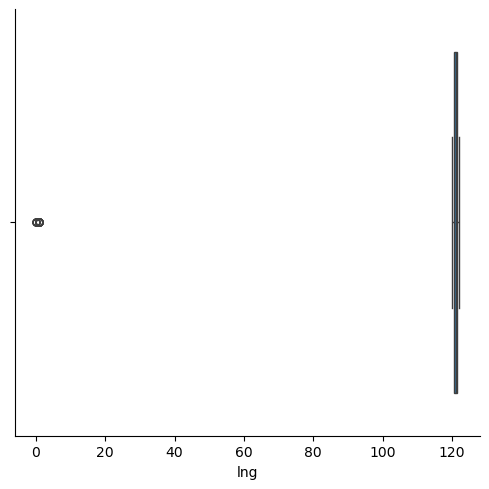

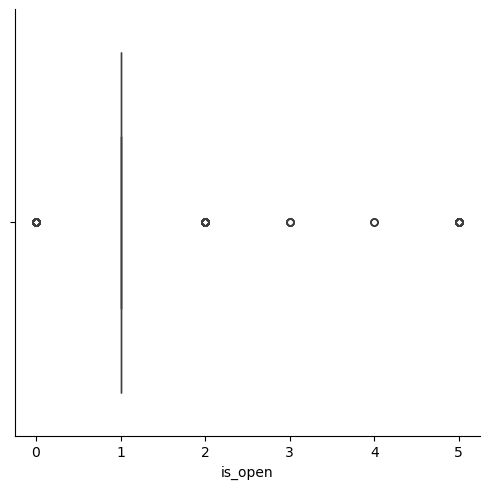

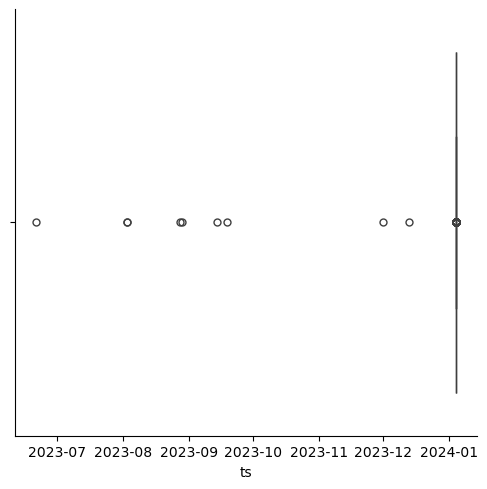

In [55]:
for col in main_df_num.columns:
    sns.catplot(kind="box", x=col, data=main_df_num)

# Clean Data

In [85]:
city_name_glossary = {"新北市": "XinBeiShi",
                      "台北市": "TaiBeiShi",
                      "台中市":"TaiZhongShi",
                      "高雄市":"KaoXiongShi",
                      "桃園市":"TaoYuanShi",
                      "臺南市": "TaiNanShi",
                      "嘉義市": "JiaYiShi",
                      "屏東縣": "PingDongXian",
                      "新竹市": "XinZhuShi",
                      "新竹縣": "XinZhuXian",
                      "苗栗縣" : "MiaoLiXian",
                      "新竹科學工業園區": "XinZhuKeXueGong"}  

#### Discard irrelevant data

In [174]:
main_df.shape

(7833, 17)

In [175]:
discard_mask = (
    (main_df["city"].isna()) #Bike stations where city is NaN are considered deprecated & removed
    | (main_df["space"] < 1) #Bike stations where space is null are discarded
    | (main_df["empty"] < 0) 
    | (main_df["full"] < 0)
    | (main_df["bike_yb1"] < 0)
    | (main_df["bike_yb2"] < 0)
    | (main_df["bike_eyb"] < 0)
               )

main_df.drop(main_df[discard_mask == True].index, inplace=True)

#### Format data

KeyError: 'TaiBeiShi'

In [180]:
main_df

,id,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb,city,lat,lng,is_open,updated_at
0,500101230,2,20,3,17,0,3,0,TaiBeiShi,25.030560,121.55252,1,1704012256
1,500312003,2,17,0,0,0,0,0,TaoYuanShi,25.050730,121.29371,0,1704012256
2,500304097,2,9,0,0,0,0,0,TaoYuanShi,24.958230,121.22700,0,1704012256
3,500304085,2,14,0,0,0,0,0,TaoYuanShi,25.012420,121.21522,0,1704012256
4,500304048,2,10,0,0,0,0,0,TaoYuanShi,24.944850,121.22283,0,1704012256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7828,1673,1,14,0,14,0,0,0,XinBeiShi,24.997780,121.51968,1,1704012209
7829,1674,1,22,3,19,3,0,0,XinBeiShi,25.024020,121.46828,1,1704012214
7830,1675,1,24,4,20,4,0,0,XinBeiShi,25.005590,121.48921,1,1704012223
7831,1676,1,14,0,13,0,0,0,XinBeiShi,24.939500,121.33867,1,1704012198


# Analyze Data


In [29]:
main_df_by_city = main_df.pivot_table(values="space", index="city", aggfunc=["sum"])

In [30]:
main_df_by_city.sort_values(by=("sum","space"))

,sum
,space
city,
XinZhuKeXueGong,740
XinZhuXian,1947
XinZhuShi,2468
JiaYiShi,2769
MiaoLiXian,2831
PingDongXian,2841
TaiNanShi,7953
TaoYuanShi,16817


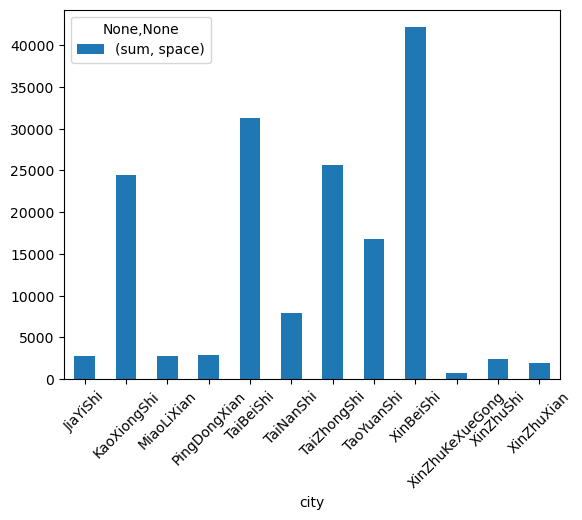

In [31]:
main_df_by_city.plot(kind="bar", rot=45)
plt.show()

In [32]:
print(main_df[["is_open"]].value_counts())

is_open
1          7090
0           473
2            84
5            47
3            10
4             5
Name: count, dtype: int64


In [ ]:
main_df[(main_df["is_open"] == 0) & (main_df["empty"] >0)].loc[:,"type":"bike_eyb"].describe()

In [47]:
main_df[(main_df["is_open"] > 1)]

,id,name,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb,city,area,lat,lng,address,is_open,updated_at
445,500399001,桃園維調(測試),2,26,1,25,0,1,0,TaoYuanShi,維調區,24.594650,121.151120,桃園市中壢區內定三街170巷201-1號,5,1703922556
592,1702,成泰路4段22巷,1,16,0,16,0,0,0,XinBeiShi,五股區,25.108260,121.455960,成泰路4段22巷29號(對面),2,1703922503
1015,500620021,大楓上楓社區活動中心,2,15,0,0,0,0,0,TaiZhongShi,大雅區,24.234454,120.666939,雅楓街106號(西南側),2,1703922556
1045,500499002,新竹市服務中心,2,0,0,0,0,0,0,XinZhuShi,維調區,1.000000,1.000000,1,5,1703922556
1046,500299011,三重服務中心,2,1,1,0,0,1,0,XinBeiShi,新北維調區,1.000000,1.000000,1,5,1703922556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7416,1108,捷運板橋站(1號出口),1,60,0,3,0,0,0,XinBeiShi,板橋區,25.013174,121.461900,縣民大道二段3號(秀泰影城門口)(鄰近板橋高鐵站),2,1703922518
7434,1129,明志國小,1,64,0,0,0,0,0,XinBeiShi,泰山區,25.045729,121.426269,明志路二段324號對面人行道(鄰近明志書院),2,1703922504
7586,1300,新北市政府(新站路),1,30,0,4,0,0,0,XinBeiShi,板橋區,25.012614,121.466455,中山路一段161號(東側出口)(鄰近新北市市民廣場),2,1703922517
7697,1437,成州國小,1,12,0,12,0,0,0,XinBeiShi,五股區,25.099230,121.450630,成泰路三段493號(東側),2,1703922509


<Axes: >

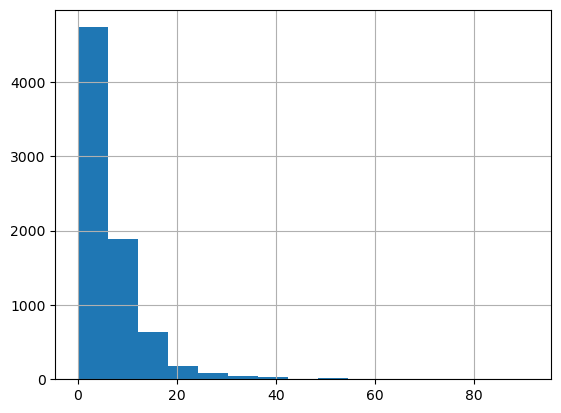

In [66]:
main_df_occupancy = main_df.pivot_table(values="

### Transfer to clean df

In [37]:
bikes_station_clean = main_df.copy()